![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 8 - CNN Architectures</center>
### <center> Transfer Learning </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/MainTransferLearning.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary

from torch.optim import lr_scheduler

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/08_CnnArchitectures/DeepLearningFramework ./DeepLearningFramework

In [5]:
from DeepLearningFramework.Training import TrainClassficationModel

### Load dataset:
https://www.kaggle.com/puneet6060/intel-image-classification

In [6]:
#-- Colab:
#-- Mount your drive before running this
if 'google.colab' in str(get_ipython()):
    !unzip "./drive/My Drive/Colab Notebooks/archive.zip"

In [7]:
import torchvision
import torchvision.transforms as transforms

#-- ImageNet statistics:
vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    transforms.Resize    (150),
    transforms.CenterCrop(150),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

trainPath = 'C:/Users/oryai/Workarea/Data/IntelSceneClassification/seg_train/seg_train'
testPath  = 'C:/Users/oryai/Workarea/Data/IntelSceneClassification/seg_test/seg_test'

oTrainSet = torchvision.datasets.ImageFolder(root=trainPath, transform=oTransforms)
oTestSet  = torchvision.datasets.ImageFolder(root=testPath,  transform=oTransforms)
oTrainSet.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

#### Plot images:

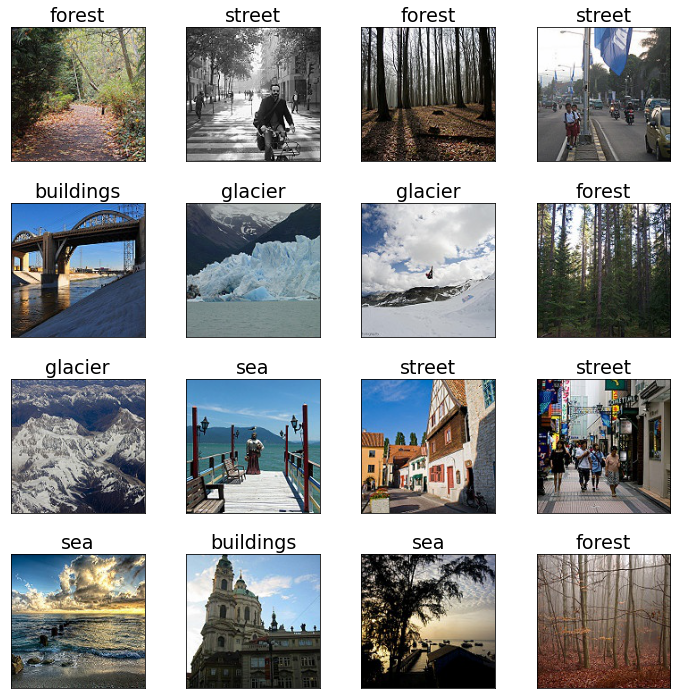

In [8]:
oTrainDL         = torch.utils.data.DataLoader(oTrainSet, batch_size=16, shuffle=True)
mImages, vLabels = next(iter(oTrainDL))

fig, _  = plt.subplots(4, 4, figsize=(10, 10))
for ii, ax in enumerate(fig.axes):
    ax.imshow    (np.clip(mImages[ii].numpy().transpose((1,2,0)) * vStd + vMean, 0, 1))
    ax.set_title (oTrainSet.classes[vLabels[ii]])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

### Train a new ResNet (without transfer learning):

In [11]:
import torch.nn as nn
import torchsummary

def GetModel():
    return torchvision.models.resnet50(pretrained=False, num_classes=6)

torchsummary.summary(GetModel(), (3, 150, 150), device='cpu');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,096
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,384
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
#-- Data loaders:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss()

In [14]:
nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = GetModel().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = lr_scheduler.OneCycleLR(oOptim, max_lr=3e-2, total_steps=nIter)

lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss: 1.37281 | Val loss: 40846.31038 | Train Accuracy: 0.5272 | Val Accuracy: 0.1750 | epoch time: 29.348 | <-- Checkpoint!
Epoch 001: | Train loss: 1.22880 | Val loss: 1.35496 | Train Accuracy: 0.5120 | Val Accuracy: 0.4740 | epoch time: 24.892 | <-- Checkpoint!
Epoch 002: | Train loss: 0.98353 | Val loss: 1.26962 | Train Accuracy: 0.6064 | Val Accuracy: 0.5463 | epoch time: 25.009 | <-- Checkpoint!
Epoch 003: | Train loss: 0.78375 | Val loss: 1.11756 | Train Accuracy: 0.6972 | Val Accuracy: 0.6327 | epoch time: 24.849 | <-- Checkpoint!
Epoch 004: | Train loss: 0.66890 | Val loss: 0.71066 | Train Accuracy: 0.7510 | Val Accuracy: 0.7377 | epoch time: 24.836 | <-- Checkpoint!
Epoch 005: | Train loss: 0.57778 | Val loss: 1.09224 | Train Accuracy: 0.7921 | Val Accuracy: 0.6523 | epoch time: 24.852 |
Epoch 006: | Train loss: 0.50930 | Val loss: 0.71132 | Train Accuracy: 0.8173 | Val Accuracy: 0.7553 | epoch time: 24.918 | <-- Checkpoint!
Epoch 007: | Train loss: 0.44216

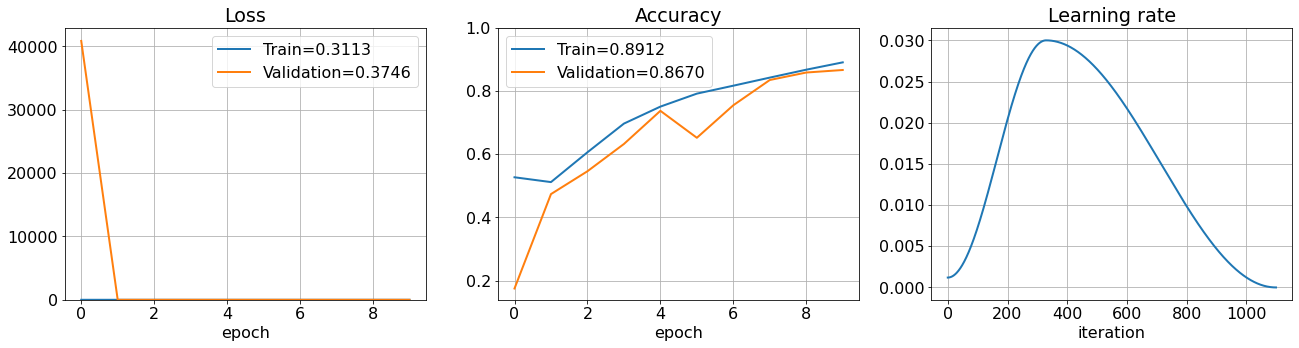

In [15]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Use a pretrained ResNet (transfer learning):

In [17]:
oTransforms = transforms.Compose([
    transforms.Resize    (224),
    transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

oTrainSet = torchvision.datasets.ImageFolder(root=trainPath, transform=oTransforms)
oTestSet  = torchvision.datasets.ImageFolder(root=testPath,  transform=oTransforms)

batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

In [19]:
def GetPretrainedModel():
    oModel = torchvision.models.resnet50(pretrained=True)
    #-- freeze weights:
    for mParam in oModel.parameters():
        mParam.requires_grad = False
        
    #-- Replace classifier head:
    dIn = oModel.fc.in_features
    oModel.fc = nn.Sequential(
        nn.Linear(dIn, 100), nn.ReLU(),
        nn.Linear(100, 6)
    )
    
    return oModel

torchsummary.summary(GetPretrainedModel(), (3, 224, 224), device='cpu');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = GetPretrainedModel().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = lr_scheduler.OneCycleLR(oOptim, max_lr=3e-2, total_steps=nIter)

lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss: 0.45174 | Val loss: 0.38347 | Train Accuracy: 0.8389 | Val Accuracy: 0.8613 | epoch time: 20.348 | <-- Checkpoint!
Epoch 001: | Train loss: 0.37318 | Val loss: 0.40335 | Train Accuracy: 0.8674 | Val Accuracy: 0.8550 | epoch time: 19.969 |
Epoch 002: | Train loss: 0.41289 | Val loss: 0.28727 | Train Accuracy: 0.8494 | Val Accuracy: 0.8943 | epoch time: 19.632 | <-- Checkpoint!
Epoch 003: | Train loss: 0.34271 | Val loss: 0.34538 | Train Accuracy: 0.8804 | Val Accuracy: 0.8730 | epoch time: 19.635 |
Epoch 004: | Train loss: 0.29649 | Val loss: 0.30917 | Train Accuracy: 0.8978 | Val Accuracy: 0.8950 | epoch time: 19.628 | <-- Checkpoint!
Epoch 005: | Train loss: 0.27238 | Val loss: 0.29433 | Train Accuracy: 0.9058 | Val Accuracy: 0.8917 | epoch time: 19.666 |
Epoch 006: | Train loss: 0.24233 | Val loss: 0.23868 | Train Accuracy: 0.9109 | Val Accuracy: 0.9103 | epoch time: 19.702 | <-- Checkpoint!
Epoch 007: | Train loss: 0.21157 | Val loss: 0.24064 | Train Accurac

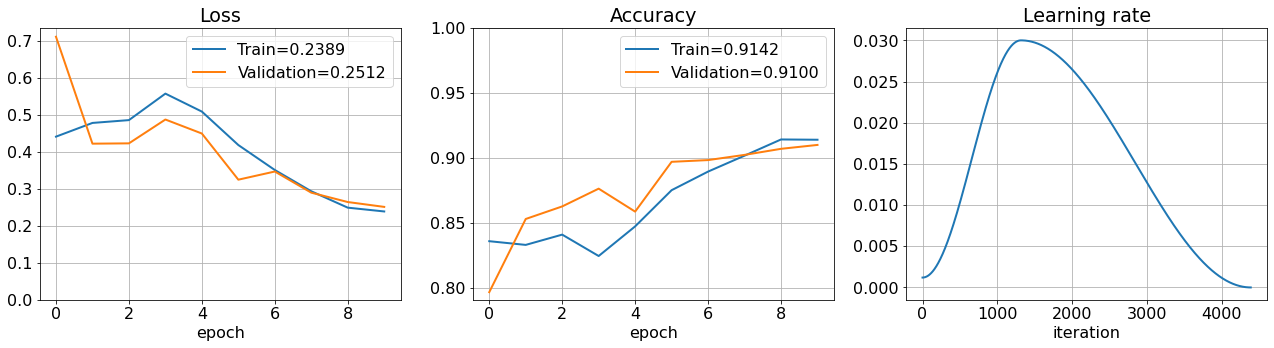

In [52]:
PlotHistory(lHistory)
plt.show   ()